### Links

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab

### Tasks

#### Include check points to automatically save only the best model
We use the best recorded model for evaluations 

#### Explore the data
We have found that the MICs are discrete multiples of 2. Thus we can interpret the problem in terms of classification

#### Try more k-mears
We are working with 4-mers but we want to go to 10-mers

#### Try unbalanced class approach
With raw approach we find decent results. Check the link above

#### Try to comput the accuracy considering +/- 1 2-fold 

Reproduce the Fig. 3 of the paper

#### Try CNN-1D, specially when we use the 10-mers since the number of bins is going to increase a lot

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers.convolutional import Conv1D
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout    
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
path_local = "../data"
data1 = pd.read_csv(f"{path_local}/tetramers_mics_matrix.csv", delimiter=',', index_col=0)

In [3]:
data1.head(n=5)

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,nalidixic acid,ampicillin,sulfisoxazole,cefoxitin,tetracycline,ceftiofur,amoxicillin/clavulanic acid,streptomycin,azithromycin,kanamycin
0,0.010195,0.009592,0.009397,0.010176,0.007437,0.007577,0.010206,0.005423,0.006263,0.008236,...,4.0,1.0,16.0,4.0,32.0,0.5,1.0,8.0,8.0,NaN
1,0.010449,0.009637,0.009843,0.010463,0.007509,0.007464,0.010087,0.005524,0.006698,0.008495,...,4.0,1.0,256.0,4.0,32.0,1.0,1.0,64.0,8.0,NaN
2,0.010097,0.009737,0.009135,0.010075,0.007710,0.007822,0.010148,0.005425,0.006208,0.008100,...,4.0,1.0,32.0,4.0,32.0,0.5,1.0,4.0,8.0,NaN
3,0.010247,0.009551,0.009677,0.010202,0.007336,0.007510,0.010134,0.005421,0.006495,0.008521,...,4.0,1.0,32.0,4.0,32.0,1.0,1.0,8.0,8.0,NaN
4,0.010307,0.009660,0.009587,0.010329,0.007443,0.007574,0.010206,0.005528,0.006474,0.008381,...,32.0,1.0,64.0,2.0,4.0,0.5,1.0,4.0,4.0,NaN


#### simple visualization

In [4]:
for col in range(len(data1.columns)):
    print(col, data1.columns[col])

0 AAAA
1 AAAC
2 AAAG
3 AAAT
4 AACA
5 AACC
6 AACG
7 AACT
8 AAGA
9 AAGC
10 AAGG
11 AAGT
12 AATA
13 AATC
14 AATG
15 AATT
16 ACAA
17 ACAC
18 ACAG
19 ACAT
20 ACCA
21 ACCC
22 ACCG
23 ACCT
24 ACGA
25 ACGC
26 ACGG
27 ACGT
28 ACTA
29 ACTC
30 ACTG
31 AGAA
32 AGAC
33 AGAG
34 AGAT
35 AGCA
36 AGCC
37 AGCG
38 AGCT
39 AGGA
40 AGGC
41 AGGG
42 AGTA
43 AGTC
44 AGTG
45 ATAA
46 ATAC
47 ATAG
48 ATAT
49 ATCA
50 ATCC
51 ATCG
52 ATGA
53 ATGC
54 ATGG
55 ATTA
56 ATTC
57 ATTG
58 CAAA
59 CAAC
60 CAAG
61 CACA
62 CACC
63 CACG
64 CAGA
65 CAGC
66 CAGG
67 CATA
68 CATC
69 CATG
70 CCAA
71 CCAC
72 CCAG
73 CCCA
74 CCCC
75 CCCG
76 CCGA
77 CCGC
78 CCGG
79 CCTA
80 CCTC
81 CGAA
82 CGAC
83 CGAG
84 CGCA
85 CGCC
86 CGCG
87 CGGA
88 CGGC
89 CGTA
90 CGTC
91 CTAA
92 CTAC
93 CTAG
94 CTCA
95 CTCC
96 CTGA
97 CTGC
98 CTTA
99 CTTC
100 GAAA
101 GAAC
102 GACA
103 GACC
104 GAGA
105 GAGC
106 GATA
107 GATC
108 GCAA
109 GCAC
110 GCCA
111 GCCC
112 GCGA
113 GCGC
114 GCTA
115 GGAA
116 GGAC
117 GGCA
118 GGCC
119 GGGA
120 GGTA
121 GTAA
122 GTAC
123

4.0
4.0
32.0


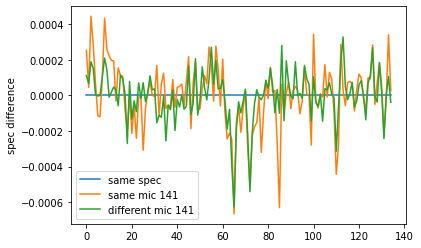

In [5]:
print(np.array(data1)[0,141])
print(np.array(data1)[1,141])
print(np.array(data1)[4,141])

#plt.plot(np.array(data1)[0,:135])
#plt.plot(np.array(data1)[4,:135])
plt.plot(np.array(data1)[0,:135]-np.array(data1)[0,:135], label="same spec")
plt.plot(np.array(data1)[1,:135]-np.array(data1)[0,:135], label="same mic 141")
plt.plot(np.array(data1)[4,:135]-np.array(data1)[0,:135], label="different mic 141")

plt.legend()
plt.ylabel('spec difference')
plt.show()

#### Resample (good practice)

In [6]:
data2 = data1.sample(frac=1, random_state=123)
data2.head(n=5)

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,nalidixic acid,ampicillin,sulfisoxazole,cefoxitin,tetracycline,ceftiofur,amoxicillin/clavulanic acid,streptomycin,azithromycin,kanamycin
1069,0.010238,0.009562,0.009783,0.010243,0.007410,0.007609,0.010194,0.005527,0.006678,0.008581,...,4.0,1.0,256.0,8.0,32.0,1.0,1.0,32.0,2.0,NaN
737,0.010048,0.009553,0.009545,0.010175,0.007346,0.007537,0.010228,0.005455,0.006327,0.008347,...,4.0,1.0,32.0,4.0,4.0,1.0,1.0,NaN,4.0,8.0
1925,0.010193,0.009492,0.009843,0.010280,0.007409,0.007539,0.010081,0.005482,0.006774,0.008639,...,4.0,1.0,256.0,4.0,32.0,1.0,1.0,NaN,4.0,8.0
1516,0.010388,0.009766,0.009647,0.010482,0.007602,0.007653,0.010085,0.005537,0.006636,0.008294,...,4.0,1.0,64.0,4.0,32.0,1.0,1.0,64.0,4.0,NaN
1134,0.010243,0.009571,0.009551,0.010335,0.007320,0.007642,0.010165,0.005525,0.006494,0.008428,...,2.0,1.0,32.0,2.0,4.0,1.0,1.0,NaN,4.0,8.0


#### It is common to replace null or nan values with a numerical value

In [7]:
data2 = data2.fillna(-9999)

In [8]:
data2.head(n=5)

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,nalidixic acid,ampicillin,sulfisoxazole,cefoxitin,tetracycline,ceftiofur,amoxicillin/clavulanic acid,streptomycin,azithromycin,kanamycin
1069,0.010238,0.009562,0.009783,0.010243,0.007410,0.007609,0.010194,0.005527,0.006678,0.008581,...,4.0,1.0,256.0,8.0,32.0,1.0,1.0,32.0,2.0,-9999.0
737,0.010048,0.009553,0.009545,0.010175,0.007346,0.007537,0.010228,0.005455,0.006327,0.008347,...,4.0,1.0,32.0,4.0,4.0,1.0,1.0,-9999.0,4.0,8.0
1925,0.010193,0.009492,0.009843,0.010280,0.007409,0.007539,0.010081,0.005482,0.006774,0.008639,...,4.0,1.0,256.0,4.0,32.0,1.0,1.0,-9999.0,4.0,8.0
1516,0.010388,0.009766,0.009647,0.010482,0.007602,0.007653,0.010085,0.005537,0.006636,0.008294,...,4.0,1.0,64.0,4.0,32.0,1.0,1.0,64.0,4.0,-9999.0
1134,0.010243,0.009571,0.009551,0.010335,0.007320,0.007642,0.010165,0.005525,0.006494,0.008428,...,2.0,1.0,32.0,2.0,4.0,1.0,1.0,-9999.0,4.0,8.0


#### Explore the MIC column in order to check the balance between values

In [87]:
#mic_column = "ceftriaxone"
mic_column = "sulfisoxazole"

In [88]:
data2[mic_column]

1069    256.0
737      32.0
1925    256.0
1516     64.0
1134     32.0
        ...  
1122     16.0
1346    256.0
1406     16.0
1389     64.0
1534    256.0
Name: sulfisoxazole, Length: 1937, dtype: float64

In [89]:
mic_reps= data2.pivot_table(index=[mic_column], aggfunc='size')
mic_reps

sulfisoxazole
16.0     275
32.0     713
64.0     283
128.0     17
256.0    649
dtype: int64

In [91]:
print("highest label contain %.2f%% of the mics"%((649/1937)*100))

highest label contain 33.51% of the mics


#### we may cut the unbalanced one in order to check if classification works at all (checked)

so we back to the full set of mics

In [92]:
mic_threshold = 0.0

In [93]:
data3 = data2[data2[mic_column] > mic_threshold]
data3.shape

(1937, 151)

In [94]:
mic = np.log2(data3[mic_column].values).astype(int)
mic.shape

(1937,)

In [95]:
print(len(np.unique(mic)), "classes obtained from log2(mic) ", np.unique(mic))

5 classes obtained from log2(mic)  [4 5 6 7 8]


#### transformation from discrete classes to onehot format

In [213]:
#by definition we need to reshape the list of mics
print(mic)

mic_reshape = np.reshape(mic,(-1,1))
print(mic_reshape[:10], "\n\nDimensions of discrete classes", mic_reshape.shape, "\n")

#define encoder function
encoder = OneHotEncoder(sparse=False)

# transform data from numerical cat to onehot code
mic_onehot = encoder.fit_transform(mic_reshape)
print(mic_onehot[:10], "\n\nDimensions of one hot classes: ", mic_onehot.shape)

[8 5 8 ... 4 6 8]
[[8]
 [5]
 [8]
 [6]
 [5]
 [5]
 [4]
 [5]
 [8]
 [8]] 

Dimensions of discrete classes (1937, 1) 

[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] 

Dimensions of one hot classes:  (1937, 5)


In [97]:
X = data3.values[:,0:136]
y = mic_onehot

print(X.shape, y.shape)

(1937, 136) (1937, 5)


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [99]:
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)

(1743, 136) (1743, 5) (194, 136) (194, 5)


In [100]:
X_train[:5,:5]

array([[0.01019181, 0.00953891, 0.0096918 , 0.01028893, 0.00741911],
       [0.01031233, 0.00981044, 0.00929958, 0.01041278, 0.00777897],
       [0.01015528, 0.00956137, 0.0093097 , 0.01024985, 0.00745586],
       [0.01021885, 0.00967007, 0.0094716 , 0.01030015, 0.00746138],
       [0.01025816, 0.00968174, 0.00936038, 0.01026986, 0.00755663]])

In [101]:
y_train[:5]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### We standardize the input samples (good practice)

In [102]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [103]:
X_train.shape

(1743, 136)

In [104]:
y_train.shape

(1743, 5)

In [105]:
X_train[:5,:5]

array([[-0.13508282, -1.15090431,  1.0767321 ,  0.1766698 , -0.85798147],
       [ 1.03781766,  2.07576225, -1.04117918,  1.45954906,  2.55823482],
       [-0.49064317, -0.8839228 , -0.98652221, -0.22807421, -0.50907439],
       [ 0.128073  ,  0.40772384, -0.11231835,  0.29293188, -0.45662537],
       [ 0.51062369,  0.54642995, -0.71287578, -0.0208366 ,  0.44758598]])

#### NN for classification

if we use more and more layers we get overfit, so we have to balance the network. anyway, during training we always save the best model only, so if there is overfit we just save the best one

In [106]:
mic_onehot.shape

(1937, 5)

In [198]:
model = Sequential()
model.add(Dense(64, input_shape=(136, ), activation='relu', name='input'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(mic_onehot.shape[1], activation='softmax', name='output'))

In [199]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#### We fit with a validation method in order to test overfit, also we checkpoint the best model for later test

overvit can be found when the train loss is small but validation loss is big

In [200]:
filepath="cnn_class_mic.h5"
earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-7)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, min_lr=0.000000001)
callbacks=[reduce_lr, checkpoint, earlystopper]

In [201]:
history = model.fit(X_train, y_train, epochs=4000, batch_size=128, validation_split=0.3, callbacks=callbacks)

Epoch 1/4000
 1/10 [==>...........................] - ETA: 0s - loss: 1.7111 - accuracy: 0.1484
Epoch 00001: val_loss improved from inf to 1.53346, saving model to cnn_class_mic.h5
10/10 [==============================] - 0s 37ms/step - loss: 1.6109 - accuracy: 0.2311 - val_loss: 1.5335 - val_accuracy: 0.3824 - lr: 0.0010
Epoch 2/4000
 1/10 [==>...........................] - ETA: 0s - loss: 1.5471 - accuracy: 0.3516
Epoch 00002: val_loss improved from 1.53346 to 1.46015, saving model to cnn_class_mic.h5
10/10 [==============================] - 0s 16ms/step - loss: 1.5093 - accuracy: 0.3590 - val_loss: 1.4601 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 3/4000
10/10 [==============================] - ETA: 0s - loss: 1.4477 - accuracy: 0.4172
Epoch 00003: val_loss improved from 1.46015 to 1.40002, saving model to cnn_class_mic.h5
10/10 [==============================] - 0s 19ms/step - loss: 1.4477 - accuracy: 0.4172 - val_loss: 1.4000 - val_accuracy: 0.4837 - lr: 0.0010
Epoch 4/4000
 1/10 [

Epoch 54/4000
 1/10 [==>...........................] - ETA: 0s - loss: 0.7740 - accuracy: 0.6328
Epoch 00054: val_loss did not improve from 0.91409
10/10 [==============================] - 0s 12ms/step - loss: 0.7365 - accuracy: 0.6869 - val_loss: 0.9437 - val_accuracy: 0.6501 - lr: 0.0010
Epoch 55/4000
 1/10 [==>...........................] - ETA: 0s - loss: 0.8135 - accuracy: 0.6328
Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00055: val_loss did not improve from 0.91409
10/10 [==============================] - 0s 11ms/step - loss: 0.7389 - accuracy: 0.6828 - val_loss: 0.9582 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 56/4000
 1/10 [==>...........................] - ETA: 0s - loss: 0.7663 - accuracy: 0.6641
Epoch 00056: val_loss did not improve from 0.91409
10/10 [==============================] - 0s 12ms/step - loss: 0.7458 - accuracy: 0.6762 - val_loss: 0.9320 - val_accuracy: 0.6501 - lr: 5.0000e-04
Epoch 57/4000
 1/10 [==>..................

#### Now, we can visualize the history of the model fit 

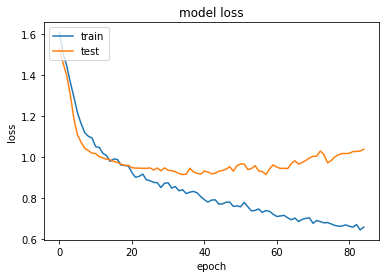

In [202]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### ROC plot

In [203]:
from sklearn.metrics import roc_curve
y_test_flat = y_test.flatten()
y_pred_flat = model.predict(X_test).flatten()

print(y_test_flat[:20])
print(np.round_(y_pred_flat[:20], decimals = 2))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.flat, y_pred_flat)

[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.39 0.5  0.11 0.   0.   0.23 0.55 0.23 0.   0.   0.43 0.49 0.08 0.
 0.   0.32 0.52 0.16 0.   0.  ]


In [204]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.8969271442236156


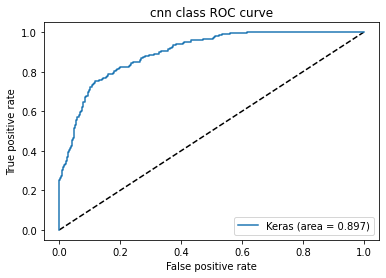

In [205]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('cnn class ROC curve')
plt.legend(loc='best')
plt.show()

####  Load the best model and test the predictions. First a couple of ones and then over the samples

First, we test the predictions on train sample just to check that the model at least predict well what is actually fitting. Later we predict on the test sample to explore the level of extrapolation of the model

In [206]:
model_from_file = load_model(filepath)

In [207]:
y_train[:10]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [208]:
pred = model_from_file.predict(X_train[:10])
np.round_(pred, decimals = 2) 

array([[0.01, 0.05, 0.01, 0.  , 0.92],
       [0.27, 0.52, 0.19, 0.  , 0.01],
       [0.26, 0.49, 0.22, 0.  , 0.03],
       [0.27, 0.53, 0.19, 0.  , 0.01],
       [0.26, 0.6 , 0.13, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.01, 0.04, 0.01, 0.  , 0.95],
       [0.29, 0.56, 0.15, 0.  , 0.  ],
       [0.26, 0.5 , 0.21, 0.  , 0.02]], dtype=float32)

In [209]:
y_test[50:60]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [210]:
pred = model_from_file.predict(X_test[50:60])
np.round_(pred, decimals = 2) 

array([[0.26, 0.43, 0.24, 0.01, 0.06],
       [0.26, 0.52, 0.2 , 0.  , 0.02],
       [0.22, 0.37, 0.24, 0.04, 0.12],
       [0.26, 0.49, 0.22, 0.  , 0.03],
       [0.03, 0.09, 0.03, 0.01, 0.85],
       [0.16, 0.34, 0.19, 0.05, 0.26],
       [0.25, 0.62, 0.13, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.26, 0.48, 0.23, 0.  , 0.03],
       [0.  , 0.01, 0.  , 0.  , 0.98]], dtype=float32)

#### evaluate model on train

In [211]:
# evaluate the model
scores = model_from_file.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f" % (model_from_file.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model_from_file.metrics_names[1], scores[1]*100))

loss: 0.82
accuracy: 66.55%


#### evaluate model on test

In [212]:
# evaluate the model
scores = model_from_file.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f" % (model_from_file.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model_from_file.metrics_names[1], scores[1]*100))

loss: 0.92
accuracy: 64.95%
